3. In this problem you manually train a multilayer perceptron (MLP) deep neural network using only numpy. Do not use tf.keras, PyTorch, scikitlearn, etc. – just use numpy. The purpose of this problem is to understand backprop and its implementation before we hand the calculation to PyTorch Autograd.

This problem uses the same MNIST image classification problem as Problem 1. So you should build upon the Python code you wrote for the feedforward (inference) processing. The file mnist traindata.hdf5 contains 60,000 images in the key xdata and the corresponding labels in the key ydata. The format is same as before. Extract these. Split into 50,000 training images and 10,000 validation images. Create a neural network for classification. It must have 784 neurons in the input layer and 10 neurons in the output layer. You may use any number of intermediate layers with any number of neurons. It must be a fully connected MLP (don’t use convolutional or other layers). Construct your MLP with:
a. Hidden layer activations: Try tanh and ReLU. Write your own functions for these, and their derivatives. Note: derivative of ReLU at 0 can be any number in [0,1].
b. Cost function: Cross entropy.
c. Optimizer: Stochastic gradient descent. Try 3 different values for learning rate. Momentum is optional. Remember that you can only use numpy, so momentum will complicate things.
d. Minibatch size: Your choice. Pick a number between 50 and 1000 that divides by 50,000 (don’t pick 123 for example). Average the gradients for each minibatch for weight and bias updates – e.g., minibatch size of 100 means 50,000/100 = 500 updates per epoch.
e. Regularizer: Your choice. If you choose to use it be mindful when calculating cost gradient.
f. Parameter initialization: Your choice. Don’t initialize weights with zeroes. You can use random values like wij ∼ U[0, 1] or wij ∼ N (0, 1) or use a standard algorithm like He or Xavier normal.
g. Input preprocessing, batch normalization: None
Train the network for 50 epochs using the 50,000 training images. Complete a forward pass with the validation set at the end of each epoch and record the accuracy (e.g., 9630 correct out of 10000 means accuracy is 96.3%). DO NOT use the validation set for training. Perform only forward inference with the validation set.

In [ ]:
# Importing the necessary libraries. 
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Extracting the data from the file.
open_file = 'mnist_traindata.hdf5'
with h5py.File(open_file, 'r') as columns:
    file_datacols = np.array(columns)
    print(file_datacols)

['xdata' 'ydata']


In [ ]:
# Converting the data to an array.
open_file = 'mnist_traindata.hdf5' # Training dataset.
with h5py.File(open_file, 'r') as columns:
    xdata = np.float32(np.array(columns['xdata']))
    ydata = np.float32(np.array(columns['ydata']))

# Splitting the train dataset into 2 parts- 50,000 for training the model and 10,000 for the model validation.
xdatatrain = xdata[0:50000, :]
ydatatrain = ydata[0:50000, :]
print('Dimensions of xdata: ', xdatatrain.shape)
print('Dimensions of ydata: ', ydatatrain.shape)
xdatavalidate = xdata[50000:,:]
ydatavalidate = ydata[50000:,:]
print('Dimensions of xdata: ', xdatavalidate.shape)
print('Dimensions of ydata: ', ydatavalidate.shape)

Dimensions of xdata:  (50000, 784)
Dimensions of ydata:  (50000, 10)
Dimensions of xdata:  (10000, 784)
Dimensions of ydata:  (10000, 10)


In [ ]:
def ReLU(x):
    y = np.zeros([len(x),])
    
    for i in range(len(x)):
        
        if x[i] < 0:
            y[i] = 0
        else:
            y[i] = x[i]
    
    return y

def cond_ReLU(x):
    return (x > 0) * 1

In [ ]:
def tanh(x):
    y = np.array(x)
    tan = (np.exp(y) - np.exp(-y)) / (np.exp(y) + np.exp(-y))
    
    return tan

def cond_tanh(x):
    y = np.array(x)
    return 4 / (np.exp(y) + np.exp(-y))

In [ ]:
def Soft_Max(x):
    x -= np.max(x)
    numerator = np.float32(np.exp(x))
    denominator = np.sum(numerator, axis = 0)
    prediction = numerator / denominator
    
    return prediction

In [ ]:
# Function parameter: w1, w2 and w3 -> weight values; b1, b2 and b3 -> bias values; batch_size -> batch for the epoch; learn_rate -> learning rate; x and y -> dataset elements.
def tanh_training(w1, w2, w3, b1, b2, b3, batch_size, learn_rate, x, y):
    samples, data = x.shape
    weights1 = np.zeros([w1.shape[0], w1.shape[1]])
    weights2 = np.zeros([w2.shape[0], w2.shape[1]])
    weights3 = np.zeros([w3.shape[0], w3.shape[1]])
    bias1 = np.zeros([b1.shape[0],])
    bias2 = np.zeros([b2.shape[0],])
    bias3 = np.zeros([b3.shape[0],])
    accuracy = 0

    for i in range(samples):
        xi = x[i]
        # Activation function calculation:
        act_relu1 = tanh(np.matmul(w1, xi) + b1)
        act_relu2 = tanh(np.matmul(w2, act_relu1) + b2)
        act_relu3 = Soft_Max(np.matmul(w3, act_relu2) + b3)
        
        if np.argmax(act_relu3) == np.argmax(y[i]):
            accuracy += 1

        # Computation of deltas:
        delta_3 = act_relu3 - y[i]
        weights3 += np.outer(delta_3, act_relu2.T)
        bias3 += delta_3
        delta_2 = np.matmul(w3.T, delta_3) * cond_tanh(act_relu2)
        weights2 += np.outer(delta_2, act_relu1.T)
        bias2 += delta_2
        delta_1 = np.matmul(w2.T, delta_2) * cond_tanh(act_relu1)
        weights1 += np.outer(delta_1, xi.T)
        bias1 += delta_1

        if (i + 1) % batch_size == 0:
            w1 -= learn_rate * (weights1 / batch_size)
            w2 -= learn_rate * (weights2 / batch_size)
            w3 -= learn_rate * (weights3 / batch_size)
            b1 -= learn_rate * (bias1 / batch_size)
            b2 -= learn_rate * (bias2 / batch_size)
            b3 -= learn_rate * (bias3 / batch_size)
            weights1 = np.zeros([w1.shape[0], w1.shape[1]])
            weights2 = np.zeros([w2.shape[0], w2.shape[1]])
            weights3 = np.zeros([w3.shape[0], w3.shape[1]])
            bias1 = np.zeros([b1.shape[0],])
            bias2 = np.zeros([b2.shape[0],])
            bias3 = np.zeros([b3.shape[0],])

    return w1, w2, w3, b1, b2, b3, accuracy / samples 

# Function parameter: w1, w2 and w3 -> weight values; b1, b2 and b3 -> bias values; x and y -> dataset elements.
def tanh_forwardpropagation(w1, w2, w3, b1, b2, b3, x, y):
    samples, data = x.shape
    accuracy = 0
    
    for i in range(samples):
        xi = x[i]
        # Activation function calculation:
        act_relu1 = tanh(np.matmul(w1, xi) + b1)
        act_relu2 = tanh(np.matmul(w2, act_relu1) + b2)
        act_relu3 = Soft_Max(np.matmul(w3,act_relu2) + b3)

        if np.argmax(y[i]) == np.argmax(act_relu3):
            accuracy += 1

    return accuracy / samples 

In [ ]:
# Function parameter: w1, w2 and w3 -> weight values; b1, b2 and b3 -> bias values; batch_size -> batch for the epoch; learn_rate -> learning rate; x and y -> dataset elements.
def ReLU_training(w1, w2, w3, b1, b2, b3, batch_size, learn_rate, x, y):
    samples, data = x.shape
    weights1 = np.zeros([w1.shape[0], w1.shape[1]])
    weights2 = np.zeros([w2.shape[0], w2.shape[1]])
    weights3 = np.zeros([w3.shape[0], w3.shape[1]])
    bias1 = np.zeros([b1.shape[0],])
    bias2 = np.zeros([b2.shape[0],])
    bias3 = np.zeros([b3.shape[0],])
    accuracy = 0

    for i in range(samples):
        xi = x[i]
        # Activation function calculation:
        act_relu1 = ReLU(np.matmul(w1, xi) + b1)
        act_relu2 = ReLU(np.matmul(w2, act_relu1) + b2)
        act_relu3 = Soft_Max(np.matmul(w3, act_relu2) + b3)
        
        if np.argmax(act_relu3) == np.argmax(y[i]):
            accuracy += 1

        # Computation of deltas:
        delta_3 = act_relu3 - y[i]
        weights3 += np.outer(delta_3, act_relu2.T)
        bias3 += delta_3
        delta_2 = np.matmul(w3.T, delta_3) * cond_ReLU(act_relu2)
        weights2 += np.outer(delta_2, act_relu1.T)
        bias2 += delta_2
        delta_1 = np.matmul(w2.T, delta_2) * cond_ReLU(act_relu1)
        weights1 += np.outer(delta_1, xi.T)
        bias1 += delta_1

        if (i + 1) % batch_size == 0:
            w1 -= learn_rate * (weights1 / batch_size)
            w2 -= learn_rate * (weights2 / batch_size)
            w3 -= learn_rate * (weights3 / batch_size)
            b1 -= learn_rate * (bias1 / batch_size)
            b2 -= learn_rate * (bias2 / batch_size)
            b3 -= learn_rate * (bias3 / batch_size)
            weights1 = np.zeros([w1.shape[0], w1.shape[1]])
            weights2 = np.zeros([w2.shape[0], w2.shape[1]])
            weights3 = np.zeros([w3.shape[0], w3.shape[1]])
            bias1 = np.zeros([b1.shape[0],])
            bias2 = np.zeros([b2.shape[0],])
            bias3 = np.zeros([b3.shape[0],])

    return w1, w2, w3, b1, b2, b3, accuracy / samples 

# Function parameter: w1, w2 and w3 -> weight values; b1, b2 and b3 -> bias values; x and y -> dataset elements.
def ReLU_forwardpropagation(w1, w2, w3, b1, b2, b3, x, y):
    samples, data = x.shape
    accuracy = 0
    
    for i in range(samples):
        xi = x[i]
        # Activation function calculation:
        act_relu1 = ReLU(np.matmul(w1, xi) + b1)
        act_relu2 = ReLU(np.matmul(w2, act_relu1) + b2)
        act_relu3 = Soft_Max(np.matmul(w3, act_relu2) + b3)

        if np.argmax(y[i]) == np.argmax(act_relu3):
            accuracy += 1

    return accuracy / samples

(a) Learning rate decay: Divide the initial learning rate by 2 twice during training. You can do this after any epoch, for example, after epochs 20 and 40. (Do not do this in the middle of an epoch). Then final learning rate should be 1/4th of the initial learning rate.

Below three code blocks are the three learning rates for tanh

In [ ]:
epochTrial1 = 50
learnrate_1 = 9
learnrate_2 = 29
batch_size = 100
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer. 
w1_Trial1 = np.random.uniform(-0.01, 0.01,[200, 784])
w2_Trial1 = np.random.uniform(-0.01, 0.01,[100, 200])
w3_Trial1 = np.random.uniform(-0.01, 0.01,[10, 100])
b1_Trial1 = np.random.uniform(-0.01, 0.01,[200,])
b2_Trial1 = np.random.uniform(-0.01, 0.01,[100,])
b3_Trial1 = np.random.uniform(-0.01, 0.01,[10,])
learnrate_Trial1 = 0.02
training_accuracy_Trial1 = []
testing_accuracy_Trial1 = []

for i in range(epochTrial1):
    w1_Trial1, w2_Trial1, w3_Trial1, b1_Trial1, b2_Trial1, b3_Trial1, train_accuracy = tanh_training(w1_Trial1, w2_Trial1, w3_Trial1, b1_Trial1, b2_Trial1, b3_Trial1, batch_size, learnrate_Trial1, xdatatrain, ydatatrain)
    test_accuracy = tanh_forwardpropagation(w1_Trial1, w2_Trial1, w3_Trial1, b1_Trial1, b2_Trial1, b3_Trial1, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 9th & 29th epoch.
        learnrate_Trial1 /= 2

    training_accuracy_Trial1.append(train_accuracy)
    testing_accuracy_Trial1.append(test_accuracy)

In [ ]:
epochTrial2 = 50
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer.
w1_Trial2 = np.random.uniform(-0.01, 0.01,[200, 784])
w2_Trial2 = np.random.uniform(-0.01, 0.01,[100, 200])
w3_Trial2 = np.random.uniform(-0.01, 0.01,[10, 100])
b1_Trial2 = np.random.uniform(-0.01, 0.01,[200,])
b2_Trial2 = np.random.uniform(-0.01, 0.01,[100,])
b3_Trial2 = np.random.uniform(-0.01, 0.01,[10,])
learnrate_Trial2 = 0.03
training_accuracy_Trial2 = []
testing_accuracy_Trial2 = []

for i in range(epochTrial2):
    w1_Trial2, w2_Trial2, w3_Trial2, b1_Trial2, b2_Trial2, b3_Trial2, train_accuracy = tanh_training(w1_Trial2, w2_Trial2, w3_Trial2, b1_Trial2, b2_Trial2, b3_Trial2, batch_size, learnrate_Trial2, xdatatrain, ydatatrain)
    test_accuracy = tanh_forwardpropagation(w1_Trial2, w2_Trial2, w3_Trial2, b1_Trial2, b2_Trial2, b3_Trial2, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 9th & 29th epoch.
        learnrate_Trial2 /= 2

    training_accuracy_Trial2.append(train_accuracy)
    testing_accuracy_Trial2.append(test_accuracy)

In [ ]:
epochTrial3 = 50
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer.
w1_Trial3 = np.random.uniform(-0.01, 0.01,[200, 784])
w2_Trial3 = np.random.uniform(-0.01, 0.01,[100, 200])
w3_Trial3 = np.random.uniform(-0.01, 0.01,[10, 100])
b1_Trial3 = np.random.uniform(-0.01, 0.01,[200,])
b2_Trial3 = np.random.uniform(-0.01, 0.01,[100,])
b3_Trial3 = np.random.uniform(-0.01, 0.01,[10,])
learnrate_Trial3 = 0.04
training_accuracy_Trial3 = []
testing_accuracy_Trial3 = []

for i in range(epochTrial3):
    w1_Trial3, w2_Trial3, w3_Trial3, b1_Trial3, b2_Trial3, b3_Trial3, train_accuracy = tanh_training(w1_Trial3, w2_Trial3, w3_Trial3, b1_Trial3, b2_Trial3, b3_Trial3, batch_size, learnrate_Trial3, xdatatrain, ydatatrain)
    test_accuracy = tanh_forwardpropagation(w1_Trial3, w2_Trial3, w3_Trial3, b1_Trial3, b2_Trial3, b3_Trial3, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 9th & 29th epoch.
        learnrate_Trial3 /= 2

    training_accuracy_Trial3.append(train_accuracy)
    testing_accuracy_Trial3.append(test_accuracy)

Below three code blocks are the three learning rates for ReLU

In [ ]:
epochRelu1 = 50
learnrate_1 = 14
learnrate_2 = 34
batch_size = 50
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer.
w1_Relu1 = np.random.normal(0, 0.001, [200, 784])
w2_Relu1 = np.random.normal(0, 0.001, [100, 200])
w3_Relu1 = np.random.normal(0, 0.001, [10, 100])
b1_Relu1 = np.random.normal(0, 0.001, [200,])
b2_Relu1 = np.random.normal(0, 0.001, [100,])
b3_Relu1 = np.random.normal(0, 0.001, [10,])
learnrate_Relu1 = 0.04
training_accuracy_Relu1 = []
testing_accuracy_Relu1 = []

for i in range(epochRelu1):
    w1_Relu1, w2_Relu1, w3_Relu1, b1_Relu1, b2_Relu1, b3_Relu1, train_accuracy = ReLU_training(w1_Relu1, w2_Relu1, w3_Relu1, b1_Relu1, b2_Relu1, b3_Relu1, batch_size, learnrate_Relu1, xdatatrain, ydatatrain)
    test_accuracy = ReLU_forwardpropagation(w1_Relu1, w2_Relu1, w3_Relu1, b1_Relu1, b2_Relu1, b3_Relu1, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 14th & 34th epoch.
        learnrate_1 /= 2

    training_accuracy_Relu1.append(train_accuracy)
    testing_accuracy_Relu1.append(test_accuracy)

In [ ]:
epochRelu2 = 50
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer.
w1_Relu2 = np.random.normal(0, 0.001, [200, 784])
w2_Relu2 = np.random.normal(0, 0.001, [100, 200])
w3_Relu2 = np.random.normal(0, 0.001, [10, 100])
b1_Relu2 = np.random.normal(0, 0.001, [200,])
b2_Relu2 = np.random.normal(0, 0.001, [100,])
b3_Relu2 = np.random.normal(0, 0.001, [10,])
learnrate_Relu2 = 0.05
training_accuracy_Relu2 = []
testing_accuracy_Relu2 = []

for i in range(epochRelu2):
    w1_Relu2, w2_Relu2, w3_Relu2, b1_Relu2, b2_Relu2, b3_Relu2, train_accuracy = ReLU_training(w1_Relu2, w2_Relu2, w3_Relu2, b1_Relu2, b2_Relu2, b3_Relu2, batch_size, learnrate_Relu2, xdatatrain, ydatatrain)
    test_accuracy = ReLU_forwardpropagation(w1_Relu2, w2_Relu2, w3_Relu2, b1_Relu2, b2_Relu2, b3_Relu2, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 14th & 34th epoch.
        learnrate_2 /= 2

    training_accuracy_Relu2.append(train_accuracy)
    testing_accuracy_Relu2.append(test_accuracy)

In [ ]:
epochRelu3 = 50
# Network configuration & parameter initialization: 2 layers with 200 neurons in the first layer and 100 neurons in the second layer.
w1_Relu3 = np.random.normal(0, 0.001, [200, 784])
w2_Relu3 = np.random.normal(0, 0.001, [100, 200])
w3_Relu3 = np.random.normal(0, 0.001, [10, 100])
b1_Relu3 = np.random.normal(0, 0.001, [200,])
b2_Relu3 = np.random.normal(0, 0.001, [100,])
b3_Relu3 = np.random.normal(0, 0.001, [10,])
learnrate_Relu3 = 0.06
training_accuracy_Relu3 = []
testing_accuracy_Relu3 = []

for i in range(epochRelu3):
    w1_Relu3, w2_Relu3, w3_Relu3, b1_Relu3, b2_Relu3, b3_Relu3, train_accuracy = ReLU_training(w1_Relu3, w2_Relu3, w3_Relu3, b1_Relu3, b2_Relu3, b3_Relu3, batch_size, learnrate_Relu3, xdatatrain, ydatatrain)
    test_accuracy = ReLU_forwardpropagation(w1_Relu3, w2_Relu3, w3_Relu3, b1_Relu3, b2_Relu3, b3_Relu3, xdatavalidate, ydatavalidate)
    
    if i == learnrate_1 or i == learnrate_2: # Dividing the epoch value by 2 after 14th & 34th epoch.
        learnrate_Relu3 /= 2

    training_accuracy_Relu3.append(train_accuracy)
    testing_accuracy_Relu3.append(test_accuracy)

(b) Repeat training and validation for each of the 6 configurations — using 2 different activation functions and 3 initial learning rates. Make 6 plots each with 2 curves – training accuracy (y-axis) and validation accuracy (y-axis) vs. epoch number (x-axis). Mark the epochs where you divided learning rate.

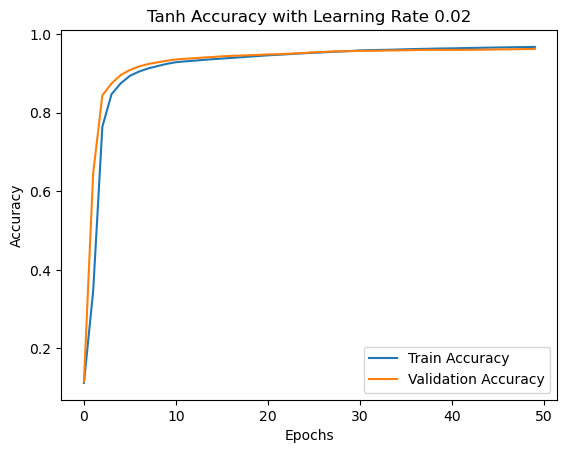

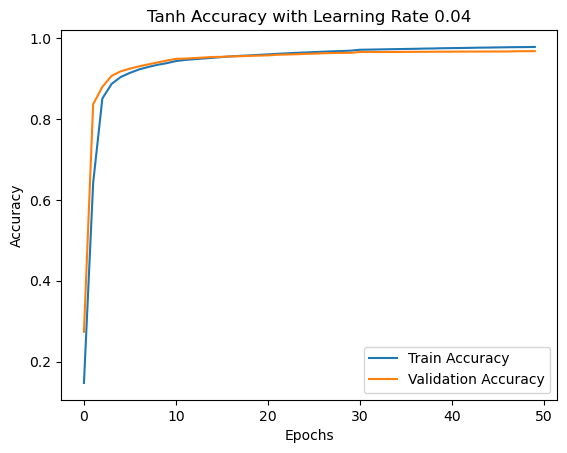

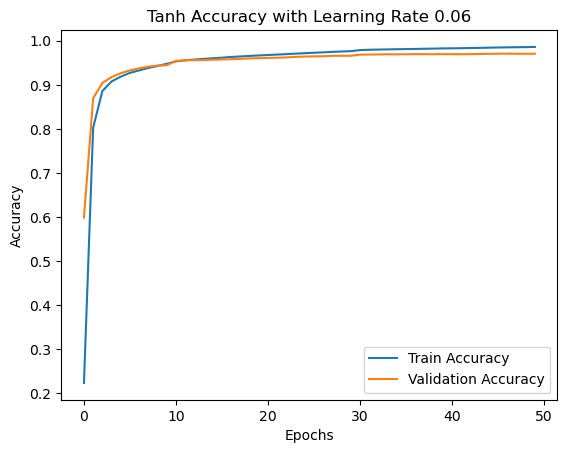

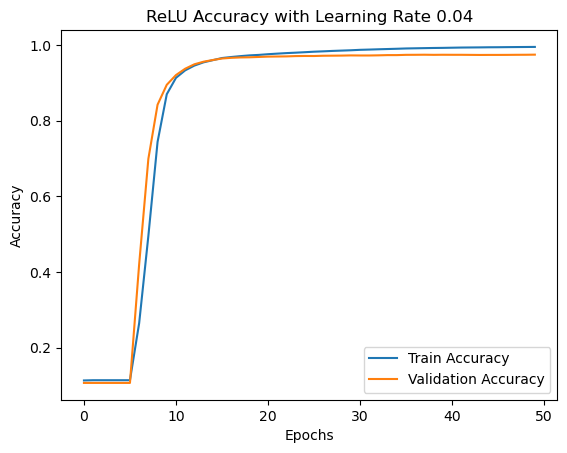

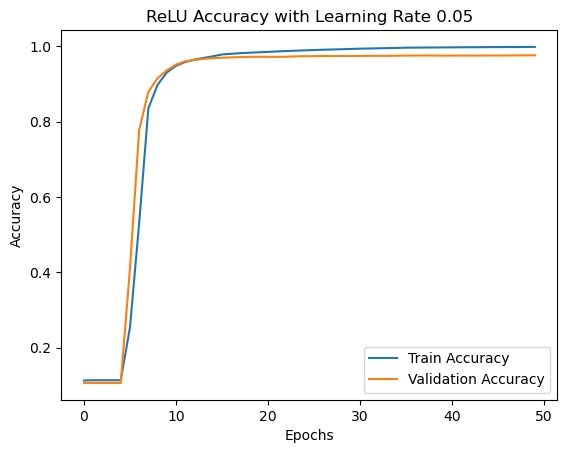

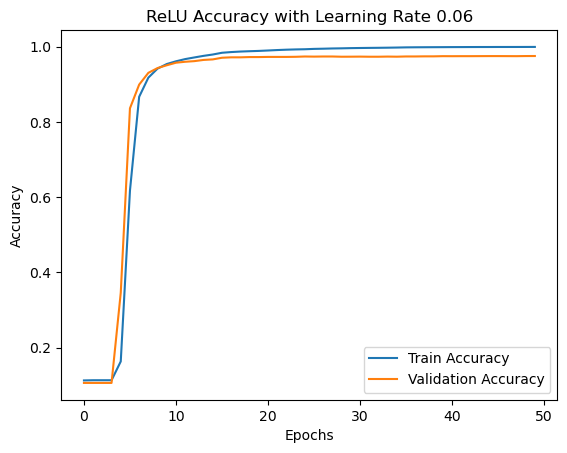

Final Tanh R = 0.02 : 0.9621
Final Tanh R = 0.03 : 0.9676
Final Tanh R = 0.04 : 0.9706
Final ReLU R = 0.04 : 0.9745
Final ReLU R = 0.05 : 0.9763
Final ReLU R = 0.06 : 0.9752


In [ ]:
fig_1 = plt.figure(1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Tanh Accuracy with Learning Rate 0.02")
plt.plot(range(epochTrial1), training_accuracy_Trial1, label = "Train Accuracy")
plt.plot(range(epochTrial1), testing_accuracy_Trial1, label = "Validation Accuracy")
plt.legend()
plt.show()

fig_2 = plt.figure(2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Tanh Accuracy with Learning Rate 0.04")
plt.plot(range(epochTrial2), training_accuracy_Trial2, label = "Train Accuracy")
plt.plot(range(epochTrial2), testing_accuracy_Trial2, label = "Validation Accuracy")
plt.legend()
plt.show()

fig_3 = plt.figure(3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Tanh Accuracy with Learning Rate 0.06")
plt.plot(range(epochTrial3), training_accuracy_Trial3, label = "Train Accuracy")
plt.plot(range(epochTrial3), testing_accuracy_Trial3, label = "Validation Accuracy")
plt.legend()
plt.show()

fig_4 = plt.figure(4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ReLU Accuracy with Learning Rate 0.04")
plt.plot(range(epochRelu1), training_accuracy_Relu1, label = "Train Accuracy")
plt.plot(range(epochRelu1), testing_accuracy_Relu1, label = "Validation Accuracy")
plt.legend()
plt.show()

fig_5 = plt.figure(5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ReLU Accuracy with Learning Rate 0.05")
plt.plot(range(epochRelu2), training_accuracy_Relu2, label = "Train Accuracy")
plt.plot(range(epochRelu2), testing_accuracy_Relu2, label = "Validation Accuracy")
plt.legend()
plt.show()

fig_6 = plt.figure(6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ReLU Accuracy with Learning Rate 0.06")
plt.plot(range(epochRelu3), training_accuracy_Relu3, label = "Train Accuracy")
plt.plot(range(epochRelu3), testing_accuracy_Relu3, label = "Validation Accuracy")
plt.legend()
plt.show()

# Multiplying the learning rate by 4 to print the original learning rate. Also, printing the final accuracy.
print("Final Tanh R =", learnrate_Trial1 * 4 , ":", testing_accuracy_Trial1[epochTrial1 - 1])
print("Final Tanh R =", learnrate_Trial2 * 4 , ":", testing_accuracy_Trial2[epochTrial2 - 1])
print("Final Tanh R =", learnrate_Trial3 * 4 , ":", testing_accuracy_Trial3[epochTrial3 - 1])
print("Final ReLU R =", learnrate_Relu1 * 4 , ":", testing_accuracy_Relu1[epochRelu1 - 1])
print("Final ReLU R =", learnrate_Relu2 * 4, ":", testing_accuracy_Relu2[epochRelu2 - 1])
print("Final ReLU R =", learnrate_Relu3 * 4, ":", testing_accuracy_Relu3[epochRelu3 - 1])

• Batch size

**Answer: -** 100 for tanh and 50 for ReLU.

• 3 different values of initial learning rate

**Answer: -** tanh- 0.02, 0.03 & 0.04; ReLU- 0.04, 0.05 & 0.06                    